### In this project, I will be building a recommender system of new york city job posting using machine learning techniques learned in second course in this specialization. Then next I will be using neural network to improve the model performance. The dataset is obtained from Kaggle, https://www.kaggle.com/new-york-city/new-york-city-current-job-postings.

This dataset contains current job postings available on the City of New York’s official jobs site (http://www.nyc.gov/html/careers/html/search/search.shtml). Internal postings available to city employees and external postings available to the general public are included. This is a dataset hosted by the City of New York. The city has an open data platform found here and they update their information according the amount of data that is brought in. Update Frequency: This dataset is updated weekly.

In [1]:
# Download the csv file
!wget https://raw.githubusercontent.com/dxljack/Advanced-Data-Science-with-IBM-Specialization/master/IBM%20Advanced%20Data%20Science%20Capstone/nyc-jobs.csv

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190919175040-0000
KERNEL_ID = 3b211f1a-2a85-4fd3-9905-0d941c77c8eb
--2019-09-19 17:50:42--  https://raw.githubusercontent.com/dxljack/Advanced-Data-Science-with-IBM-Specialization/master/IBM%20Advanced%20Data%20Science%20Capstone/nyc-jobs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17412646 (17M) [text/plain]
Saving to: 'nyc-jobs.csv'

100%[======================================>] 17,412,646  56.8MB/s   in 0.3s   

2019-09-19 17:50:43 (56.8 MB/s) - 'nyc-jobs.csv' saved [17412646/17412646]



In [2]:
# Read the csv file in spark
rdd = sc.textFile('nyc-jobs.csv')
df = spark.read.csv(rdd, header=True)

In [3]:
# Take a look at our dataset the first time
df.show()

+------+--------------------+------------+--------------+--------------------+--------------------+-------------+-----+--------------------+-----------------------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|Job ID|              Agency|Posting Type|# Of Positions|      Business Title| Civil Service Title|Title Code No|Level|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|       Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|            To Apply|         Hours/Shift|     Work Location 1| Recruitment Contact|Residency Require

In [4]:
# Take only columns necessary to the project
df1 = df[["Job ID", "Agency", "# Of Positions", "Business Title", "Job Category", "Full-Time/Part-Time indicator", "Salary Range From", "Salary Range To", "Work Location", "Job Description", "Minimum Qual Requirements", "Preferred Skills", "Additional Information"]]
df1.show()

+------+--------------------+--------------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+--------------------+-------------------------+--------------------+----------------------+
|Job ID|              Agency|# Of Positions|      Business Title|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|       Work Location|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|
+------+--------------------+--------------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+--------------------+-------------------------+--------------------+----------------------+
| 87990|DEPARTMENT OF BUS...|             1|     Account Manager|                null|                         null|            42405|          65485| 110 William St. N Y|Division of Econo...|     "1.	A baccalau

In [5]:
# Next we make sure that numerical columns are in type integer
from pyspark.sql.types import *
df1 = df1.withColumn("Salary Range From", df1["Salary Range From"].cast(IntegerType()))
df1 = df1.withColumn("Salary Range To", df1["Salary Range To"].cast(IntegerType()))
df1 = df1.withColumn("# Of Positions", df1["# Of Positions"].cast(IntegerType()))

In [6]:
# Change to pandas dataframe for easy visualization
df_p = df1.toPandas()
df_p.shape

(3228, 13)

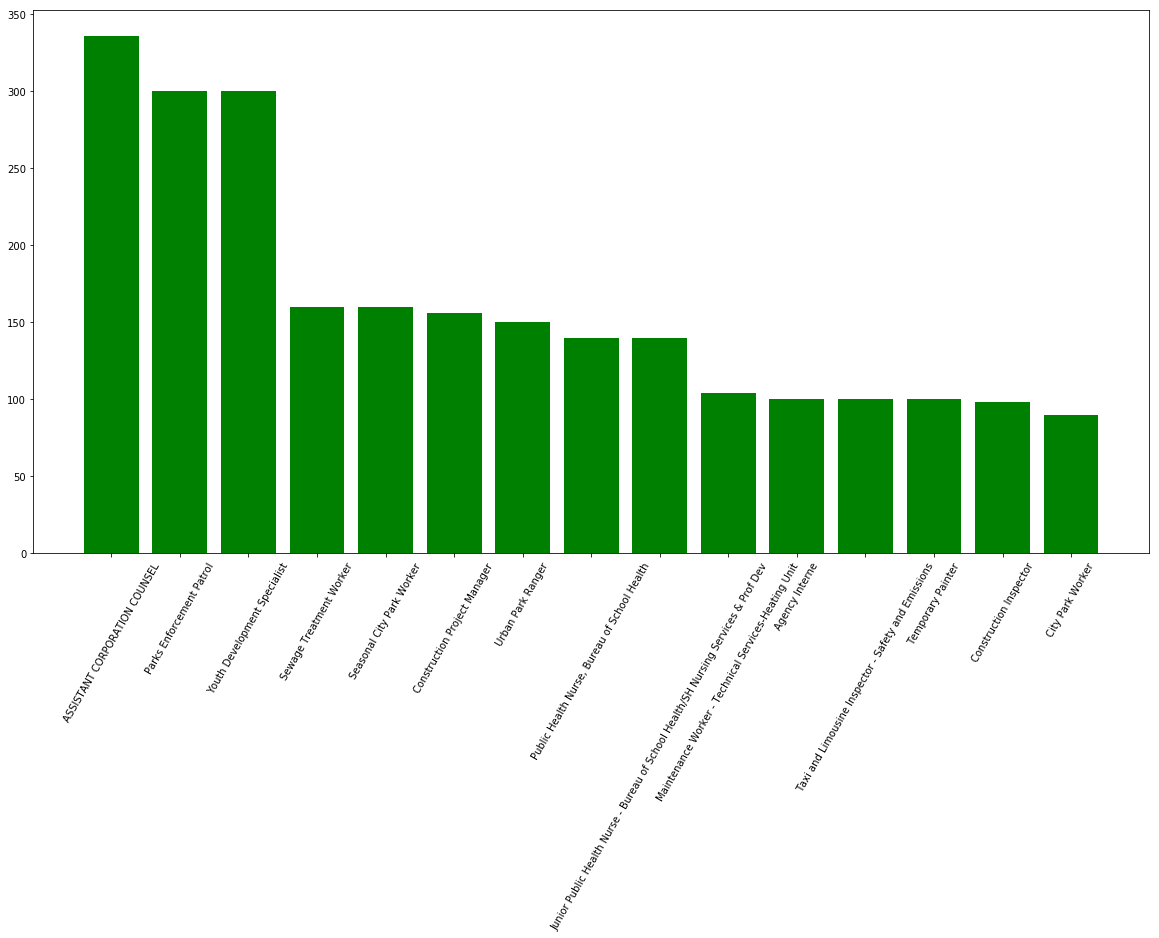

In [7]:
# Visualization on number of postions for each job
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

vacancies = df_p.groupby('Business Title')['# Of Positions'].sum().sort_values(ascending=False).head(15)
vacancies = vacancies.reset_index()

plt.figure(figsize=(20,10))
plt.bar(vacancies['Business Title'], vacancies['# Of Positions'], color='green')
plt.xticks(vacancies['Business Title'], rotation=60)
plt.show()


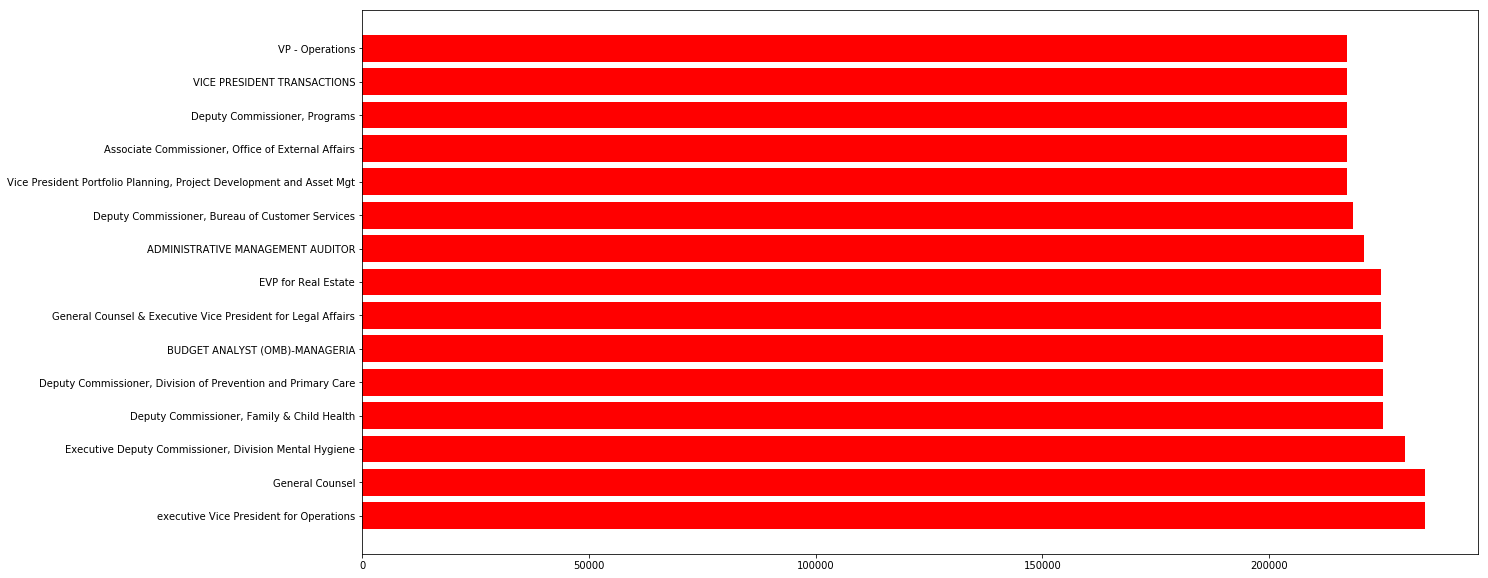

In [9]:
# Highest salary jobs
salaries = df_p.groupby('Business Title')['Salary Range To'].mean().sort_values(ascending=False).head(15)
salaries = salaries.reset_index()

plt.figure(figsize=(20,10))
plt.barh(salaries['Business Title'], salaries['Salary Range To'], color='red')
plt.yticks(salaries['Business Title'])
plt.show()

In [10]:
# Install wordcloud
!pip install wordcloud

    100% |################################| 368kB 3.5MB/s eta 0:00:01
    100% |################################| 2.1MB 3.2MB/s eta 0:00:01
    100% |################################| 20.4MB 810kB/s eta 0:00:01
tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.


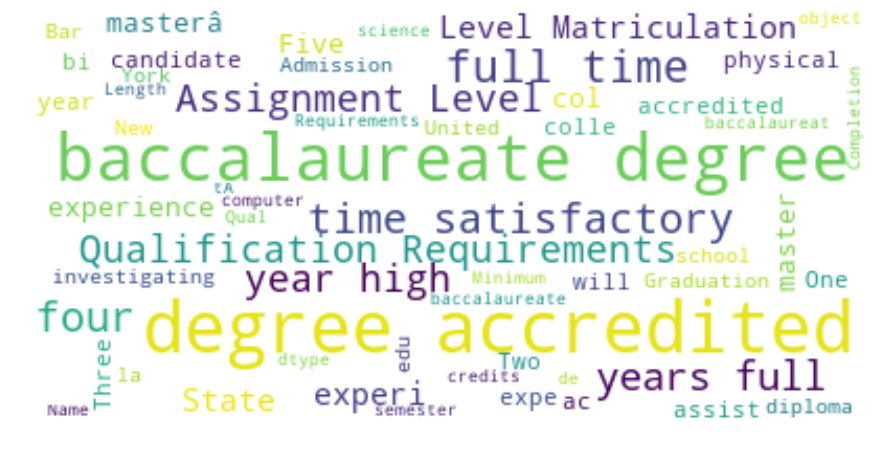

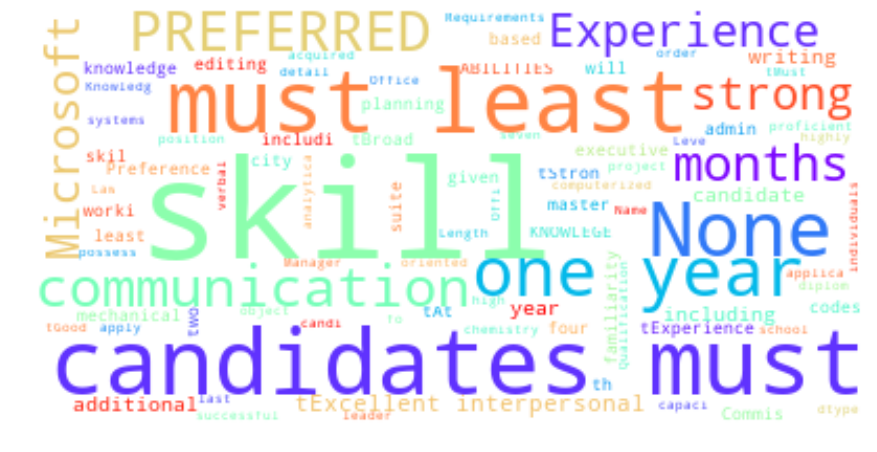

In [11]:
# Find the most occuring qualification and skill
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
stopwords.update(["english"])

# Generate a word cloud image
plt.figure(figsize=(15, 10))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=150).generate_from_text(str(df_p['Minimum Qual Requirements']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.figure(figsize=(15, 10))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap="rainbow", max_words=150).generate_from_text(str(df_p['Preferred Skills']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
# Next we observe the work location column has none address formatted entries
# However I don't have access to Google or Foursquare API, therefore I don't know the exact address of each location
# Since the entire dataset was about job postings within New York City, I have decided to drop the work location column
df1 = df1.drop('Work Location')

In [13]:
# Notice here that there are missing values
# Majority of missing values are not numerical, therefore I won't be able to impute them
# In addition, I cannot drop all missing values either since, it will reduce the dataset drastically
# However, I can impute the missing value for Full-Time/Part-Time indicator column

from pyspark.sql.functions import when

df1 = df1.withColumn("Full-Time/Part-Time indicator", \
              when(df1["Salary Range From"] > 2000, "F").otherwise(df1["Full-Time/Part-Time indicator"]))

df1 = df1.withColumn("Full-Time/Part-Time indicator", \
              when(df1["Salary Range From"] < 2000, "P").otherwise(df1["Full-Time/Part-Time indicator"]))

In [14]:
df1 = df1.withColumn("Minimum Qual Requirements", df1["Minimum Qual Requirements"].cast(StringType()))
df1 = df1.withColumn("Preferred Skills", df1["Preferred Skills"].cast(StringType()))

In [15]:
df1.show()

+------+--------------------+--------------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+-------------------------+--------------------+----------------------+
|Job ID|              Agency|# Of Positions|      Business Title|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|
+------+--------------------+--------------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+-------------------------+--------------------+----------------------+
| 87990|DEPARTMENT OF BUS...|             1|     Account Manager|                null|                            F|            42405|          65485|Division of Econo...|     "1.	A baccalaurea...| all candidates m...|  â€¢	Excellent int...|
| 97899|DEPARTMENT OF BUS...|   

In [16]:
# Now we do some feature engineering
# I would like to separete each requirement in minimum qual requirements column and preferred skills column and put them in one-hot encoding
# However, it seems to be impossible for this project because
# 1. the values are saparated by a mix of punctuation marks rather than commas
# 2. The number of string values in the column for each job is not the same
# What I will do here is to split them by semicolons and put them in a single list
from pyspark.sql.functions import split

df_qual = df1.withColumn("Minimum Qual Requirements", split("Minimum Qual Requirements", " "))

df_skill = df_qual.withColumn("Preferred Skills", split("Preferred Skills", " "))

In [17]:
# Focus on the minimum qual requirements and preferred skills columns
df_cor = df_skill[['Business Title', 'Salary Range From', 'Minimum Qual Requirements', 'Preferred Skills']]
df_cor.show()

+--------------------+-----------------+-------------------------+--------------------+
|      Business Title|Salary Range From|Minimum Qual Requirements|    Preferred Skills|
+--------------------+-----------------+-------------------------+--------------------+
|     Account Manager|            42405|     ["1.	A, baccalaur...|[, all, candidate...|
|EXECUTIVE DIRECTO...|            60740|     ["1., A, baccalau...|                null|
|Maintenance Worke...|            51907|     ["1., Three, year...|      [, mechanical]|
|Maintenance Worke...|            51907|     ["1., Three, year...|      [, mechanical]|
|   Temporary Painter|               35|     [1., Five, years,...|                null|
|   Temporary Painter|               35|     [1., Five, years,...|                null|
|    Contract Analyst|            50598|     ["1., A, baccalau...|[, individuals, m...|
|   Associate Chemist|            50623|     [Qualification, R...|[In, order, to, a...|
|Cost Estimating M...|          

In [18]:
# Count number of values in the minimum qual requirements column
from pyspark.sql.functions import size
cor1 = df_cor.select('*',size('Minimum Qual Requirements').alias('Qual Count'))

# Count number of values in the preferred skills column
cor2 = cor1.select('*',size('Preferred Skills').alias('Skills Count'))
cor2.show()

+--------------------+-----------------+-------------------------+--------------------+----------+------------+
|      Business Title|Salary Range From|Minimum Qual Requirements|    Preferred Skills|Qual Count|Skills Count|
+--------------------+-----------------+-------------------------+--------------------+----------+------------+
|     Account Manager|            42405|     ["1.	A, baccalaur...|[, all, candidate...|        71|          16|
|EXECUTIVE DIRECTO...|            60740|     ["1., A, baccalau...|                null|       140|          -1|
|Maintenance Worke...|            51907|     ["1., Three, year...|      [, mechanical]|        63|           2|
|Maintenance Worke...|            51907|     ["1., Three, year...|      [, mechanical]|        63|           2|
|   Temporary Painter|               35|     [1., Five, years,...|                null|        69|          -1|
|   Temporary Painter|               35|     [1., Five, years,...|                null|        69|      

In [19]:
# There are obvious data loss, since the preferred skills column has size -1
# Find correlations between salary and qual requirements/skills
# For some reason, I cannot get the matrix to display in correct format, ie. 3x3 
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import Normalizer

assembler = VectorAssembler(inputCols=["Salary Range From", "Qual Count", "Skills Count"], outputCol="vector_col")
assembled = assembler.transform(cor2).select('vector_col')
matrix = Correlation.corr(assembled, 'vector_col')
matrix.collect()[0]["pearson({})".format('vector_col')].values

array([ 1.        , -0.00607311,  0.16031597, -0.00607311,  1.        ,
       -0.08789125,  0.16031597, -0.08789125,  1.        ])

#### Create ETL, and upload the nyc-jobs.csv file to Cloud Object Storage

In [20]:
credentials = {

   "apikey": "oDF5lYbLsLQXa8RMBtucTdeT3g3yXGRYa9H3rJXBUltC",
   "cos_hmac_keys": {
    "access_key_id": "38428cff313d4390a5766378a14f9830", 
    "secret_access_key": "e77e2857559e362dc4231e72a7aec17e2ed5a8e935a5cb79"
   },
   "endpoints": "https://s3.us.cloud-object-storage.appdomain.cloud",
   "iam_apikey_description": "Auto-generated for key 38428cff-313d-4390-a576-6378a14f9830",
   "iam_apikey_name": "Service credentials-1",
   "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Manager",
   "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/39ab347da12e4d838644458813bd22dd::serviceid:ServiceId-5d306231-6364-4926-b25a-2d9394d33d4f",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/39ab347da12e4d838644458813bd22dd:abc5e98f-41d3-49c9-a285-c321a1be779c::"
}

In [21]:
endpoint = 'https://s3.us.cloud-object-storage.appdomain.cloud'

In [22]:
bucket_name = 'advanceddatasciencewithibm-donotdelete-pr-ix96rnitjjpbid'

In [23]:
from ibm_botocore.client import Config
import ibm_boto3 as boto3

In [24]:
resource = boto3.resource(
    's3',
    aws_access_key_id = credentials["cos_hmac_keys"]['access_key_id'],
    aws_secret_access_key = credentials["cos_hmac_keys"]["secret_access_key"],
    endpoint_url = endpoint,
)

In [25]:
client = boto3.client(
    's3',
    aws_access_key_id = credentials["cos_hmac_keys"]['access_key_id'],
    aws_secret_access_key = credentials["cos_hmac_keys"]["secret_access_key"],
    endpoint_url=endpoint,

)

In [26]:
client.upload_file(Filename='nyc-jobs.csv',Bucket=bucket_name,Key='nyc-jobs_data.csv')